## Neuron Tutorial - Modeling Exercises - Class 2
# February 29, 2024

----------------------------------------------------------------------------------------------------------------------------------
## Recap from last class: 

    1. Advantages and disadvantages for using Neuron + comparison between Neuron, Brian and NEST
    
    2. Neuron GUI
    
        - We built a 4 compartment model using CellBuilder: soma, axon, apical and basilar 
        
        - Specified Topology, Geometry and Biophysics
        
        - Added a point process 
        
        - Run model and visualize results
        
    3. Write simple .hoc code
------------------------------------------------------------------------------------------------------------------------------------


## Plan for today

1. Learn some vital NEURON syntax

2. Learn how to use NEURON - python interface 

3. Discover how to set up our first NEURON model

4. Import morphology into Neuron and use a session file
--------------------------------------------------------------------------------------------------------------------------------------------

### 1. Neuron sections and segments 

Last time we briefly discussed about the manner in which Neuron sees the world and we saw how da cell can be mapped into different **sections**. The cartoon bellow (The Neuron book,Carnevale and Hines, 2009) shows how the soma gives rise to an axon hillock that is connected to a myelinated axon. In order to build our NEURON model, we must first understand how each anatomical structure corresponds to one or more section of the model: the soma, the axon hillock, myelinated internodes, nodes of Ranvier and the dendrites. 

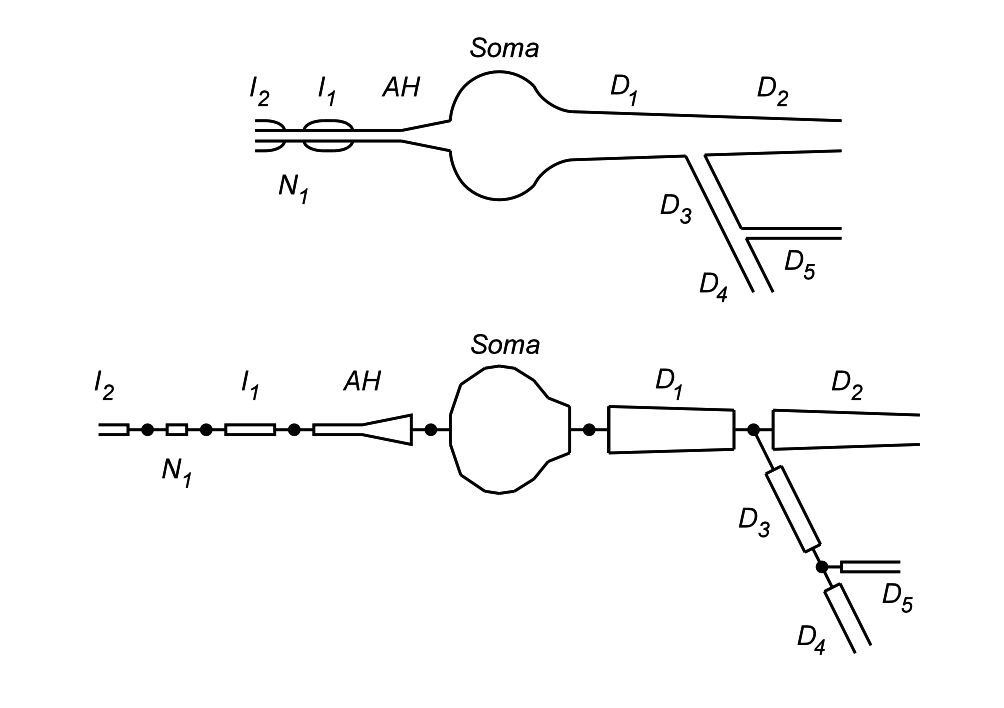

The properties that are applied to an entire section are called **section variables** and are: 

- L = section length [μm]
- Ra = cytoplasmic resistivity [Ωcm]
- nseg = number of segments - discretization parameter 

Very often neurons have sections with very different sizes. They can be long and thick or short and tiny. To deal with this problem, each section is divided into **segments**, and so we can divide big sections with many segments while we can keep small ones with less or no segmenting. Then, we can simulate the electrical activity of a whole neuron by computing the electrical dynamics of coupled sections.

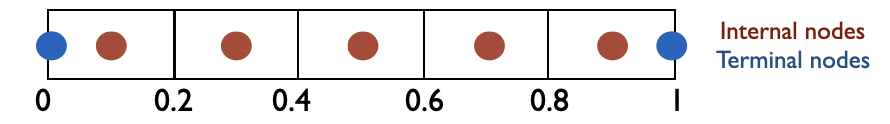


For each section we need to specify the following morphological parameters: 
- L  = section length
- diam =  diameter
- nseg =  a number of segments
- x = a relative coordinate along a section. x=0 and x=1 represent one and the other end, and x=0.5 represents a middle point.


## 2. Setting up a model in NEURON

A typical procedure of model construction and simulation in NEURON implies: 

1. Define **morphology**

2. Add **intrinsic mechanisms** in neurons

3. Set up **external stimuli** and **networks wirings**

4. **Record your data**

5. **Run** the simulation 

6. Collect **data** from recorders and save them.

If you don't have Neuron installed already, simply type: 

In [2]:
!pip install neuron

This is how we import NEURON: 

In [3]:
from neuron import h, gui
axon = h.Section(name="axon") # this is the axon

Let's see what is it in this axon:

In [4]:
h.psection()

axon { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
}


1.0

We can see that `axon` is created with default values for the shape parameters and also others such as `cm` and `Ra`, which represent *capacitance* and *axial resistance* of this section, respectively. `L=100` means that the length is 100 μm, and `diam=500` means that the diameter is 500 μm.

Let's create a long and thin axon instead. In order to change the length or any of the properties, you must simply use the dot notation:

In [5]:
axon.L = 500 # 500 um long
axon.diam = 1 # 1 um diameter 

h.psection()

axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
}


1.0

### Default units used in NEURON

|Quantity | Unit|
|:--------|:-----|
|Time | ms |
|Voltage | mV |
|Current density (distributed) | mA/cm2 |
|Current (point process) | nA |
|Concentration | mM |
|Specific capacitance | uF/cm2 |
|Length | um |
|Conductance density (distributed) | S/cm2 |
|Conductance (point process) | uS |
|Axial resistance | ohm cm |
|Resistance | Mohm|

## 3. Add membrane and intracellular mechanisms

Once the morphologies of neurons are prepared, cells are ready for embedding dynamical mechanisms. During the course, you will learn about ion channels and and other membrane/intracellular mechanisms, but here the first mechanism will be `pas`, which is a simple membrane electric resistance describing leaking of the electric current through the cellular membrane, according to the Ohm's law,

$$
i = g (v - E),
$$
where $i$ is a current density per area leaking out from the intracellular to extracellular domain. $v$ is the membrane potential, $g$ is the conductance per area, and $E$ is a parameter called the reversal potential, typically around -70 mV.

This mechanism can be inserted into the section `axon` as:

In [6]:
axon.insert("pas")

axon

Now we can check again our axon: 

In [7]:
h.psection()


axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


1.0

## 4. Add point processes

Neurons should be driven by **external stimuli** and/or other cells via **network connections**. In NEURON, these are implemented by embedding objects called **point processes** in each cell. Last class we discussed how this can be added from the GUI. 

Here, we add a simple external stimuli, which is called the [*current clamp*](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=iclamp#IClamp), which simulates an electrode that injects a certain amount of electric current for a given time period.

We will add this current clamp electrode at the x$\approx$0 location of our `axon` (one end). (x=0 is the very end and can cause an undesirable behavior)

**Note: when you change `nseg`, you have to move the electrode again!!!** 

In [8]:
ic = h.IClamp(axon(0))

`IClamp` function has three parameters (see [documentation](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=iclamp#IClamp)), delay, dur(ation), amp(litude). We set the parameters as

In [9]:
ic.delay = 0 # 0 ms delay
ic.dur = 1e2 # 100 ms duration
ic.amp = 0.200 # 200 pA

Let's check our axon one more time:

In [10]:
h.psection()

axon { nseg=1  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=1}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


1.0

## 5. Record your data 

We will record the membrane potential of this axon at three different locations, x$\approx$0, x=0.5, and x=1. For this, we will need to prepare the data placeholders called [vectors](https://www.neuron.yale.edu/neuron/static/py_doc/programming/math/vector.html) and specify how which variable at where is recorded.

So let's create a list of vectors first,

In [12]:
reclist = []
for i in range(3):
    reclist.append(h.Vector())
reclist

[Vector[6], Vector[7], Vector[8]]

Now we will record the membrane potential `v` at x=0.001, 0.5, and 1, every 0.1 ms (see [documentation](https://www.neuron.yale.edu/neuron/static/py_doc/programming/math/vector.html?highlight=vector#Vector.record) for more detail)

In [12]:
dt = 0.1
reclist[0].record(axon(1e-3)._ref_v, dt)
reclist[1].record(axon(0.5)._ref_v, dt)
reclist[2].record(axon(1)._ref_v, dt)

Vector[5]

## 6. Running simulation
In most cases, we can simply call h.init() and h.run() after setting h.tstop, which sets how long the simulation will run.

In [13]:
from neuron import h, gui

h.tstop = 100 # 100 ms duration
h.init() #initialize the simulation
h.run() #run!
h.continuerun(100)

0.0

## 7. Collecting, inspecting, and saving the data

Let's check what data we collected:

In [14]:
print(reclist[0].size())  #size of the vector that was recording the membrane potential at x = 0.001

1001


Since dt=0.1, the recorded data is a vector, [v(t=0), v(t=0.1), v(t=0.2),...,v(t=100)], whose length should be 1001. We can plot the data now.

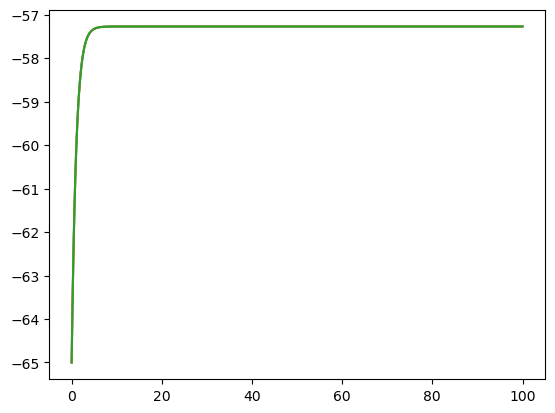

In [15]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(1001)*dt
fig, ax = plt.subplots()

ax.plot(t, reclist[0],
        t, reclist[1],
        t, reclist[2])

Here we see three curves are exactly the same since currently nseg = 1 and the section is isopotential. This is obviously not good! Let's change the number of segments and rerun our simulation:

In [16]:
axon.nseg = 100 # split the section by dx = 500/100 = 5 um.

h.psection(axon)

axon { nseg=100  L=500  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert pas { g_pas=0.001 e_pas=-70}
	insert capacitance { cm=1}
	insert morphology { diam=1}
}


1.0

Here we again put the electrode where we wanted it (because we changed the number of segments)

In [17]:
ic.get_loc()

0.0

In [18]:
ic.loc(0)

0.0

In [13]:
# Here we define a function for recording the data and running the simulation
def run_and_record():
    reclist = []
    for i in range(3):
        reclist.append(h.Vector())

    dt = 0.1 # define time step 
    reclist[0].record(axon(1e-3)._ref_v, dt)
    reclist[1].record(axon(0.5)._ref_v, dt)
    reclist[2].record(axon(1)._ref_v, dt)

    h.init()
    h.run()
    
    return(reclist)

reclist = run_and_record()

.append documentation: https://www.neuron.yale.edu/neuron/static/new_doc/programming/gui/list.html

In [20]:
print(reclist[0].size())

1001


In [21]:
  t = np.arange(1001)*dt

In [22]:
t.size


1001

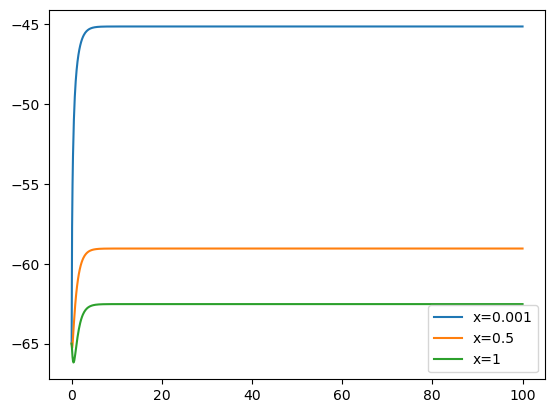

In [23]:
def plot_recordings(reclist):
    t = np.arange(1001)*dt
    fig, ax = plt.subplots()
    ax.plot(t, reclist[0], label="x=0.001")
    ax.plot(t, reclist[1], label="x=0.5")
    ax.plot(t, reclist[2], label="x=1")
    ax.legend()
    return fig


a = plot_recordings(reclist)